In [1]:

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

print('references loaded')

references loaded


In [2]:

vehicle_images = glob.glob('labeled-dataset/vehicles/**/*.png')
nonvehicle_images = glob.glob('labeled-dataset/non-vehicles/**/*.png')
print(len(vehicle_images), len(nonvehicle_images))


8792 8968


In [4]:
#from lesson #20
   
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
print ('executed')

executed


In [5]:
# from lesson 22

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)  #returns a contiguous flattened array      
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

print ('executed')

executed


In [6]:
#lesson 31
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    #nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    #ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    #nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    #ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
        
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

print ('executed')

executed


In [14]:

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis==True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features), None

print ('executed')

executed


In [49]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        # trying to fix the crash if there is any None val in features
        features1 = []
        for x in features:
            if x != None:
                features1.append(x)
        test_features = scaler.transform(np.array(features1).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# define a function for plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i +1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

print ('executed')

executed


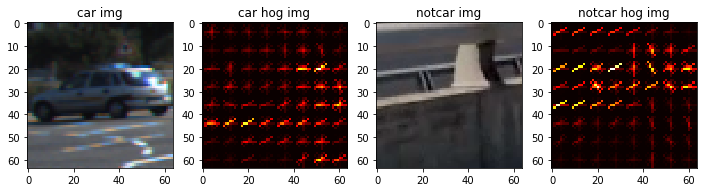

In [20]:
%matplotlib inline

#lesson 20
# choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(vehicle_images))
notcar_ind = np.random.randint(0, len(nonvehicle_images))

# Read in car / not-car images
car_image = mpimg.imread(vehicle_images[car_ind])
notcar_image = mpimg.imread(nonvehicle_images[notcar_ind])

# lesson 28
### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

# lesson 33
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

#extract_features from to this
car_features, car_hog_image = single_img_features(car_image, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car img', 'car hog img', 'notcar img', 'notcar hog img']

fig = plt.figure(figsize=(12,3))
visualize (fig, 1,4, images, titles)

In [23]:
%matplotlib inline

#lesson 20
# choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(vehicle_images))
notcar_ind = np.random.randint(0, len(nonvehicle_images))

# Read in car / not-car images
car_image = mpimg.imread(vehicle_images[car_ind])
notcar_image = mpimg.imread(nonvehicle_images[notcar_ind])

# lesson 28
### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"


# lesson 33
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

t=time.time()
n_samples = 1000
random_idxs = np.random.randint(0,len(vehicle_images), n_samples)
test_cars = np.array(vehicle_images)[random_idxs]
test_notcars = np.array(nonvehicle_images)[random_idxs]

#extract_features from to this
car_features = extract_features(test_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(test_notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print (time.time()-t , ' seconds to train a classifier...')

# converting to vertical array
x = np.vstack((car_features, notcar_features)).astype(np.float64)
# . Applying a scaler from scikit lib. fit a per-column scaler
x_scaler = StandardScaler().fit(x)
# apply the scaler to x
scaled_x = x_scaler.transform(x)

# 1's fpr cars and 0's for non-cars. define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

#split up data into randomized test set
rand_state = np.random.randint(0, 100)
x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(x_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(x_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(x_test, y_test), 4))
# Check the prediction time for a single sample

'''
t=time.time()

image = mpimg.imread('bbox-example-image.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)'''

8.12441349029541  seconds to train a classifier...
Using: 6 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1992
3.43 Seconds to train SVC...
Test Accuracy of SVC =  0.98


"\nt=time.time()\n\nimage = mpimg.imread('bbox-example-image.jpg')\ndraw_image = np.copy(image)\n\n# Uncomment the following line if you extracted training\n# data from .png images (scaled 0 to 1 by mpimg) and the\n# image you are searching is a .jpg (scaled 0 to 255)\n#image = image.astype(np.float32)/255\n\nwindows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, \n                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))\n\nhot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, \n                        spatial_size=spatial_size, hist_bins=hist_bins, \n                        orient=orient, pix_per_cell=pix_per_cell, \n                        cell_per_block=cell_per_block, \n                        hog_channel=hog_channel, spatial_feat=spatial_feat, \n                        hist_feat=hist_feat, hog_feat=hog_feat)                       \n\nwindow_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)       

In [25]:
%matplotlib inline

#lesson 20
# choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(vehicle_images))
notcar_ind = np.random.randint(0, len(nonvehicle_images))

# Read in car / not-car images
car_image = mpimg.imread(vehicle_images[car_ind])
notcar_image = mpimg.imread(nonvehicle_images[notcar_ind])

# lesson 28
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9 # as per HOG paper, it works until this limit
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL" . Works better at 'all'


# lesson 33
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

t=time.time()
n_samples = 1000
#random_idxs = np.random.randint(0,len(vehicle_images), n_samples)
test_cars = vehicle_images #np.array(vehicle_images)[random_idxs]
test_notcars = nonvehicle_images #np.array(nonvehicle_images)[random_idxs]

#extract_features from to this
car_features = extract_features(test_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(test_notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print (time.time()-t , ' seconds to train a classifier...')

# converting to vertical array
x = np.vstack((car_features, notcar_features)).astype(np.float64)
# . Applying a scaler from scikit lib. fit a per-column scaler
x_scaler = StandardScaler().fit(x)
# apply the scaler to x
scaled_x = x_scaler.transform(x)

# 1's fpr cars and 0's for non-cars. define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

#split up data into randomized test set
rand_state = np.random.randint(0, 100)
x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.1) #, random_state=rand_state

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(x_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(x_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(x_test, y_test), 4))
# Check the prediction time for a single sample

'''
t=time.time()

'''

162.09003233909607  seconds to train a classifier...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
55.07 Seconds to train SVC...
Test Accuracy of SVC =  0.9927


"\nt=time.time()\n\nimage = mpimg.imread('bbox-example-image.jpg')\ndraw_image = np.copy(image)\n\n# Uncomment the following line if you extracted training\n# data from .png images (scaled 0 to 1 by mpimg) and the\n# image you are searching is a .jpg (scaled 0 to 255)\n#image = image.astype(np.float32)/255\n\nwindows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, \n                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))\n\nhot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, \n                        spatial_size=spatial_size, hist_bins=hist_bins, \n                        orient=orient, pix_per_cell=pix_per_cell, \n                        cell_per_block=cell_per_block, \n                        hog_channel=hog_channel, spatial_feat=spatial_feat, \n                        hist_feat=hist_feat, hog_feat=hog_feat)                       \n\nwindow_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)       

0.0 1.0
0.5693418979644775  seconds to process one image searching 57 windows
0.0 1.0
0.5681493282318115  seconds to process one image searching 57 windows
0.0 1.0
0.5456929206848145  seconds to process one image searching 57 windows
0.0 1.0
0.5519917011260986  seconds to process one image searching 57 windows
0.0 1.0
0.5384280681610107  seconds to process one image searching 57 windows


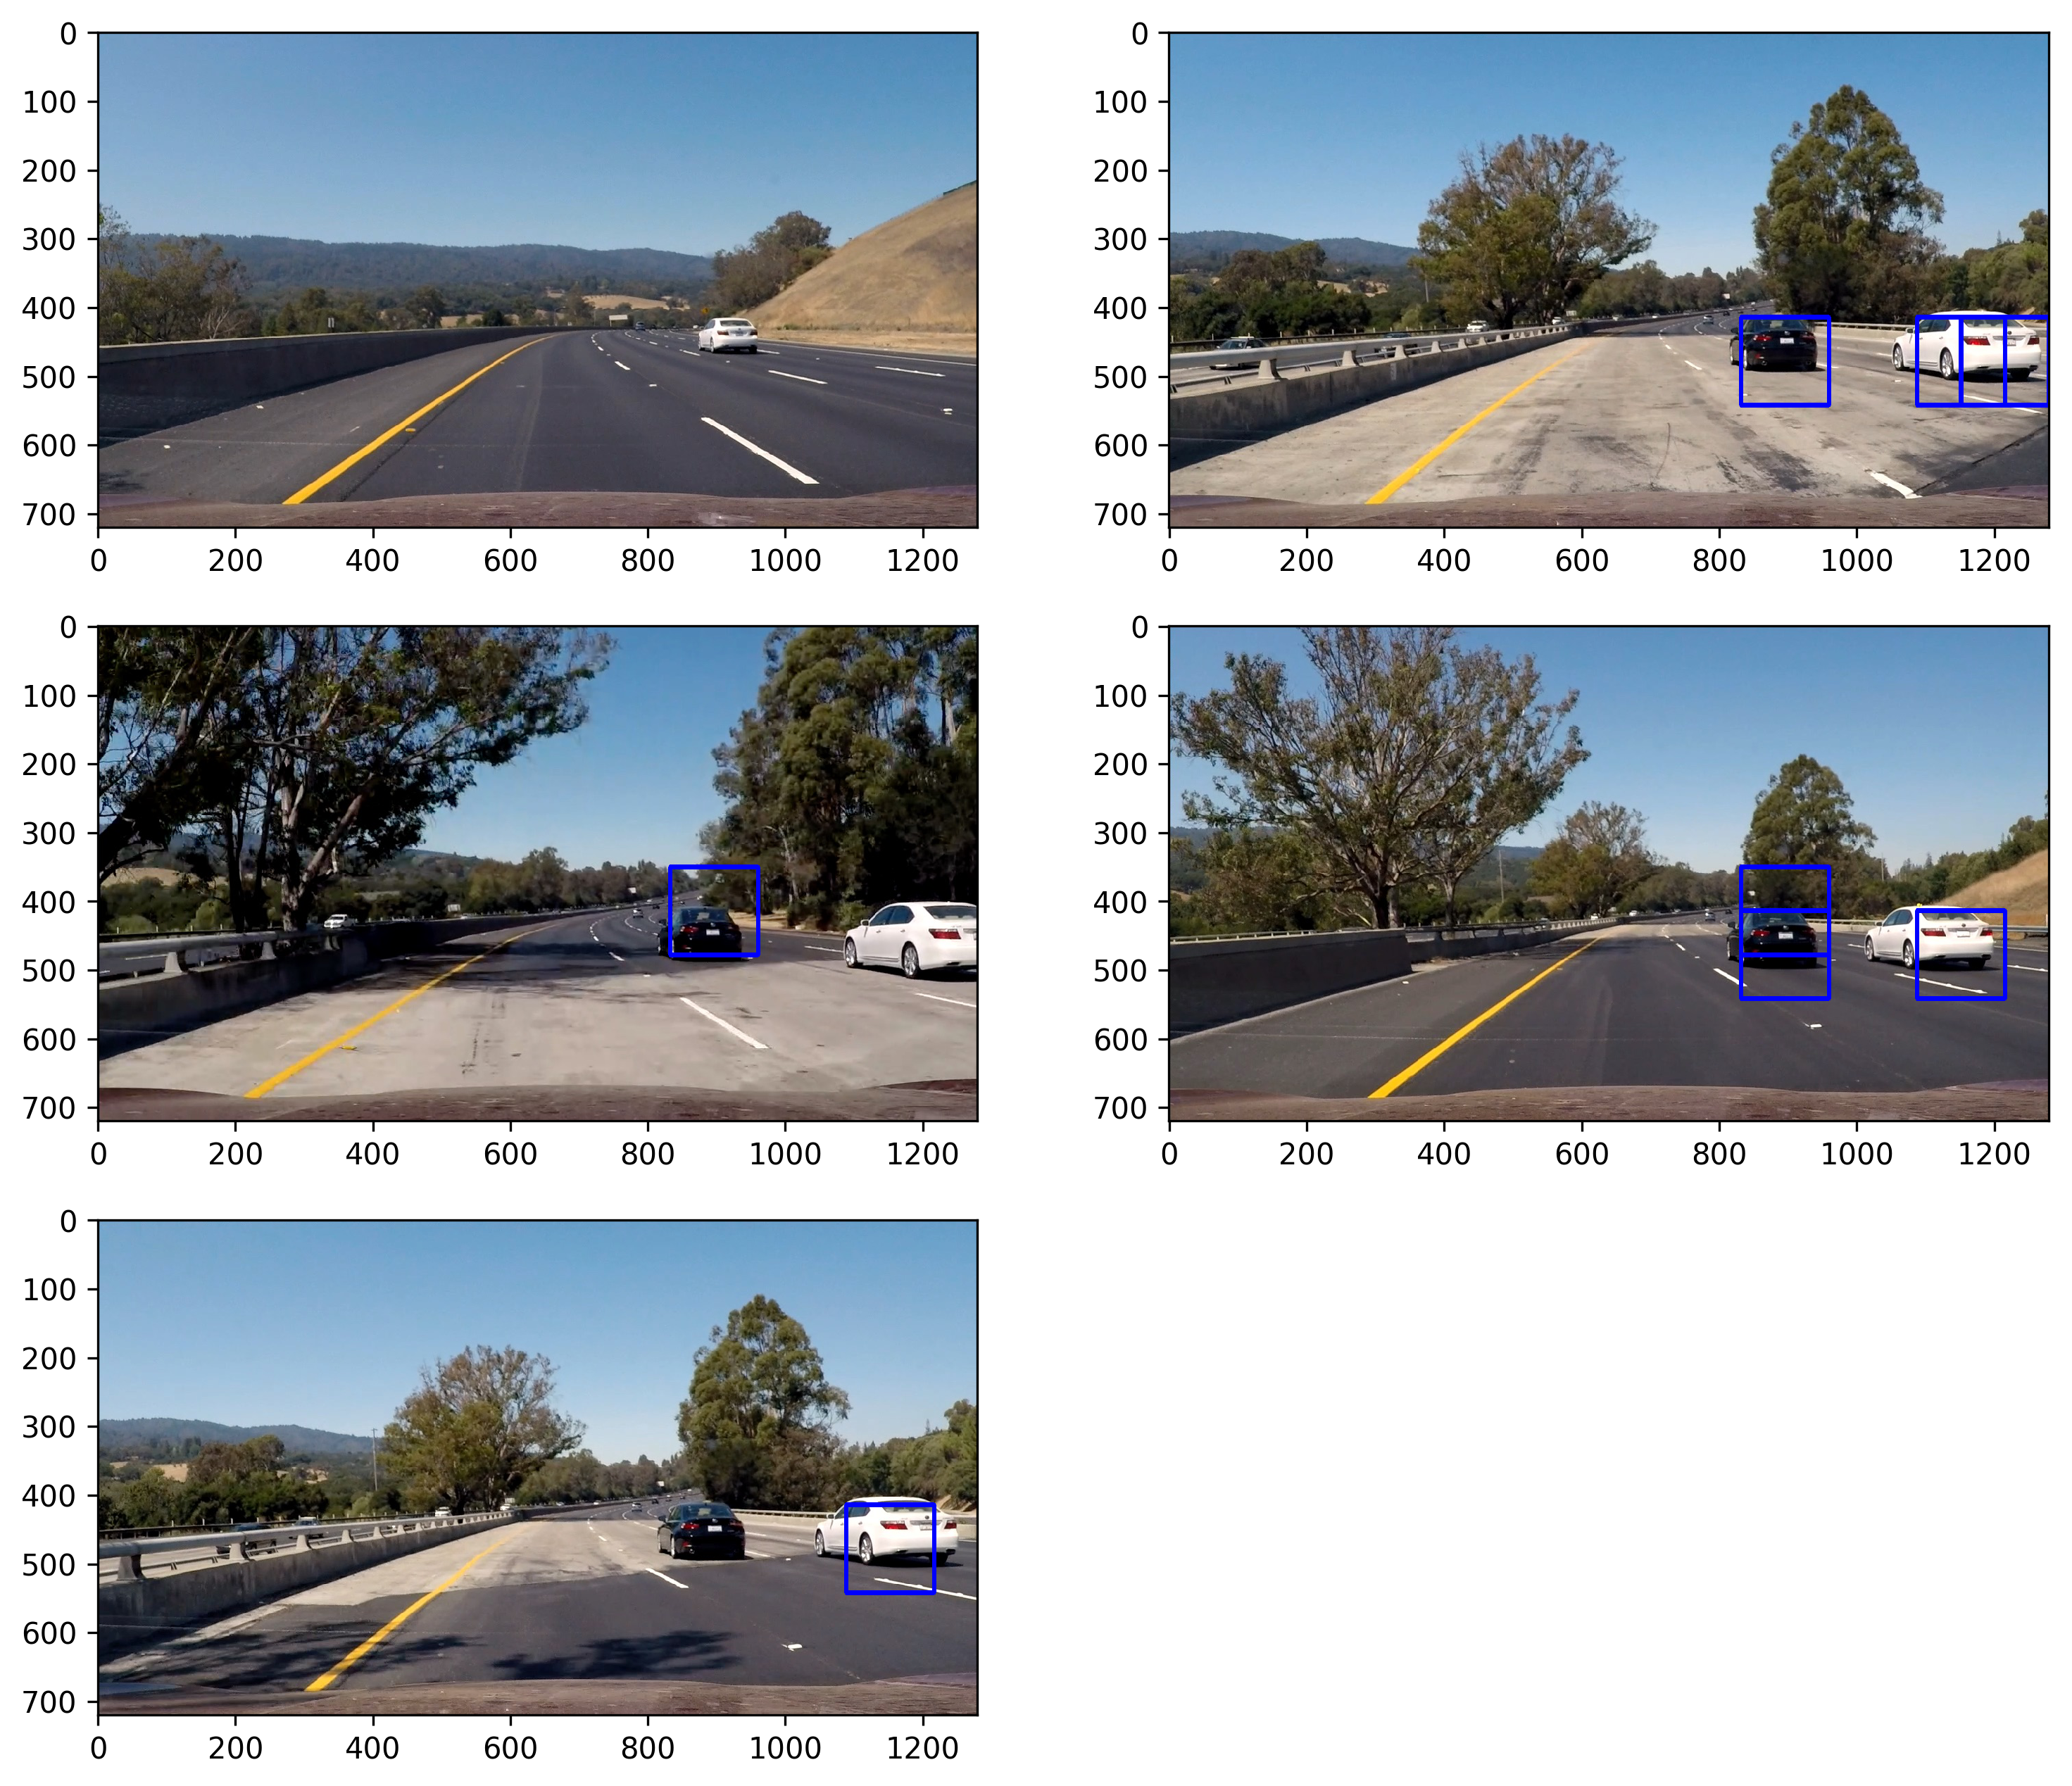

In [55]:
#multi-images test

searchpath = 'test_images/*.jpg'
example_images = glob.glob(searchpath)
images = []
titles = []
y_start_stop = [350, 656] # Min and Max in y to search in slide_window
overlap = 0.5


for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    
    draw_img = np.copy(img)
    #png files are read in 0s and 1s by mpimg so bringing jpgs to same level. It was mentioned by ryan keenan
    # in his p5 video at https://youtu.be/P2zwrTM8ueA?t=2701
    img = img.astype(np.float32)/255
    print (np.min(img), np.max(img))
    #print (hist_feat, hog_feat)
#image = mpimg.imread('bbox-example-image.jpg')
#draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(overlap, overlap))
    #windows = np.array(windows, dtype=float)
    
    hot_windows = search_windows(img, windows, svc, x_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)                    
    images.append(window_img)
    
    titles.append('')
    print (time.time()-t1, ' seconds to process one image searching', len(windows), 'windows')
    
    #plt.imshow(window_img)
fig = plt.figure (figsize=(12,18), dpi=300)
visualize(fig, 5,2, images, titles)

In [ ]:
#testing using a single image
image = mpimg.imread('bbox-example-image.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)


In [57]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    elif conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    elif conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

0.8299751281738281  seconds to run, total windows= 294
0.833554744720459  seconds to run, total windows= 294
0.8871805667877197  seconds to run, total windows= 294
0.8252644538879395  seconds to run, total windows= 294
0.8329136371612549  seconds to run, total windows= 294


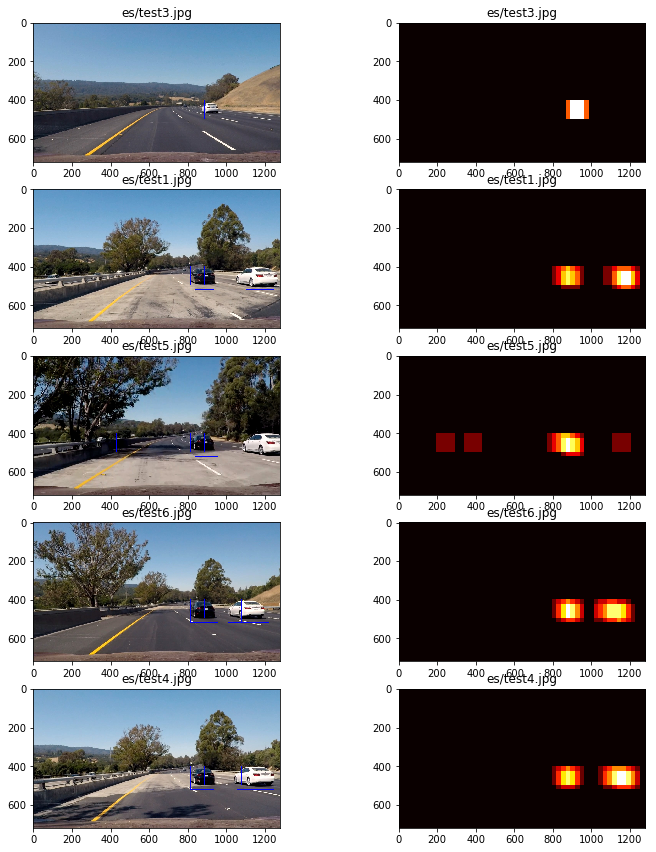

In [73]:
# taking the HOG features at once and then subsampling that array. Until now, we were extracting HOG features for each tiny 
# bit of cell block or subimage. 

out_images = []
out_maps = []
out_titles = []
out_boxes = []

#narrowing down search across Y-axis as according to Ryan we will not find cars hanging in trees. I will say not until 
# we have flying cars. Once we have them then we will come back here and change this piece of code
ystart = 400
ystop = 656
scale = 1.5 # scaling the search window size e.g instead of choosing 128x128 or 64x64, we are scaling entire image


for img_src in example_images:
    img_boxes = []
    t = time.time()
    count = 0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    # Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:] #limiting the height
    ctrans_tosearch = convert_color(img_tosearch)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1 # how many blocks across each axis
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1 # '//' division sign rounds off number
    
    nfeat_per_block = orient*cell_per_block**2 # how many features per block are we going to extract
    window = 64 # window size
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2 # instead of overlap, specify how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            # this approach might give more false +ves so need to keep an eye on that
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)) 
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            #extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = x_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart),(0,0,255))
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left:xbox_left+win_draw] += 1
    
    print(time.time()-t, ' seconds to run, total windows=', count)
    out_images.append(draw_img)
    
    out_titles.append(img_src[-12:])
    out_titles.append(img_src[-12:])
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)
    
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)
                

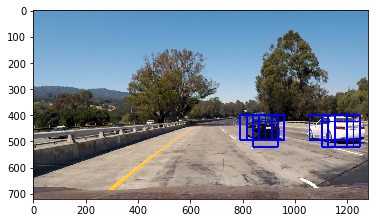

In [66]:
# DEPRECATED

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
#from lesson_functions import *
'''
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"] '''

img = mpimg.imread('test_images/test1.jpg')
X_scaler = x_scaler

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_old(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
ystart = 400
ystop = 656
scale = 1.5
    
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

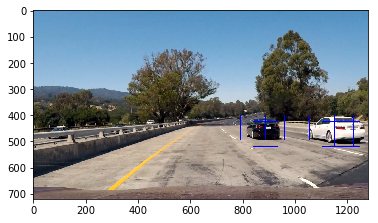

In [83]:

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
#from lesson_functions import *
'''
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"] '''

img = mpimg.imread('test_images/test1.jpg')
X_scaler = x_scaler

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img=img, ystart=ystart, ystop=ystop, scale=scale, svc=svc, X_scaler=x_scaler, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins):
    
    draw_img = np.copy(img)
    # Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:] #limiting the height
    ctrans_tosearch = convert_color(img_tosearch)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1 # how many blocks across each axis
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1 # '//' division sign rounds off number
    
    nfeat_per_block = orient*cell_per_block**2 # how many features per block are we going to extract
    window = 64 # window size
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2 # instead of overlap, specify how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            # this approach might give more false +ves so need to keep an eye on that
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)) 
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            #extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = x_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart),(0,0,255))
                #img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left:xbox_left+win_draw] += 1
    
          
    return draw_img, heatmap
    
ystart = 400
ystop = 656
scale = 1.5
    
out_img, heatmap = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)



In [68]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

# Read in image similar to one shown above 
image = mpimg.imread('test_image.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


"\n# Add heat to each box in box list\nheat = add_heat(heat,box_list)\n    \n# Apply threshold to help remove false positives\nheat = apply_threshold(heat,1)\n\n# Visualize the heatmap when displaying    \nheatmap = np.clip(heat, 0, 255)\n\n# Find final boxes from heatmap using label function\nlabels = label(heatmap)\ndraw_img = draw_labeled_bboxes(np.copy(image), labels)\n\nfig = plt.figure()\nplt.subplot(121)\nplt.imshow(draw_img)\nplt.title('Car Positions')\nplt.subplot(122)\nplt.imshow(heatmap, cmap='hot')\nplt.title('Heat Map')\nfig.tight_layout()\n"

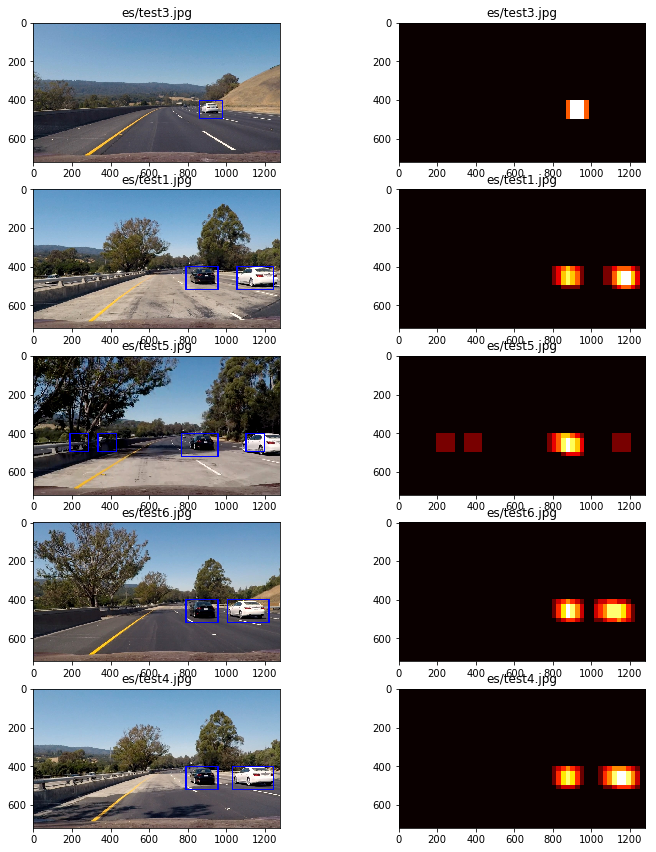

In [84]:
out_images = []
out_maps = []
ystart = 400
ystop = 656
scale = 1.5

for img_src in example_images:
    img = mpimg.imread(img_src)
    out_img, heat_map = find_cars(img=img, scale=scale)
    labels = label(heat_map)
    # draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)
    out_images.append(heat_map)
    
fig = plt.figure(figsize=(12,24))
visualize(fig, 8,2, out_images, out_titles)

In [87]:
def process_image(img):
    out_img, heat_map = find_cars(img=img, scale=scale)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [89]:
from moviepy.editor import VideoFileClip

#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [17:29<00:00,  1.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 1h 54min 5s, sys: 4min 44s, total: 1h 58min 50s
Wall time: 17min 29s
